<a href="https://colab.research.google.com/github/MicheleBonus/cpclab_notebooks/blob/main/visualize_ligand_interactions_for_uniprot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# @title
# ---- Required Libraries ----
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def fetch_data_from_url(endpoint, id, base_url="https://www.ebi.ac.uk/pdbe/graph-api"):
    """
    Fetches data from the PDBe API using the specified endpoint and ID.

    Parameters:
    - endpoint (str): The endpoint of the API.
    - id (str): The ID used in the API query.
    - base_url (str, optional): The base URL for the API. Defaults to "https://www.ebi.ac.uk/pdbe/graph-api".

    Returns:
    - dict: Data returned from the API or None if there's an exception.
    """
    url = f"{base_url}/{endpoint}/{id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while fetching data: {e}")
        return None

In [6]:
def extract_data_from_ligand_sites(ligand_sites):
    """
    Extracts specific ligand site information from the raw data.

    Parameters:
    - ligand_sites (dict): Data containing ligand sites information.

    Returns:
    - list: List of dictionaries containing extracted data.
    """
    extracted_data = []
    for data_uniprot_accession, accession_data in ligand_sites.items():
        for row in accession_data.get('data', []):
            for residue in row.get('residues', []):
                # Add extra fields to the residue data
                residue['ligand_accession'] = row.get('accession')
                residue['ligand_name'] = row.get('name')
                residue['ligand_num_atoms'] = row.get('additionalData', {}).get('numAtoms')
                residue['uniprot_accession'] = data_uniprot_accession
                residue['interaction_ratio'] = len(residue.get('interactingPDBEntries', [])) / len(residue.get('allPDBEntries', []))
                extracted_data.append(residue)
    return extracted_data

In [7]:
def extract_data_from_ligands(ligands_data):
    """
    Extracts ligand information from the raw data.

    Parameters:
    - ligands_data (dict): Data containing ligands information.

    Returns:
    - list: List of dictionaries containing extracted data.
    """
    extracted_data = []
    for data_uniprot_accession, accession_data in ligands_data.items():
        for ligand_row in accession_data:
            for ligand, attributes in ligand_row.items():
                attributes['pdbs'] = ",".join(attributes['pdbs'])
                attributes['acts_as'] = ",".join([item.strip() for item in attributes['acts_as']])
                # Merge ligand code with its attributes
                extracted_data.append({"ligand_code": ligand, **attributes})
    return extracted_data

In [8]:
def extract_data_from_ppi_sites(ppi_sites):
    """
    Processes macromolecule interaction data to extract relevant information.

    Parameters:
    - ppi_sites (dict): The interaction data.

    Returns:
    - list: Processed interaction data.
    """
    interaction_data = []

    for data_uniprot_accession in ppi_sites:
        accession_data = ppi_sites.get(data_uniprot_accession)
        length = accession_data.get('length')
        for row in accession_data.get('data', []):
            interaction_accession = row.get('accession')
            all_pdb_entries = row.get('allPDBEntries', [])
            name = row.get('name')
            # Since the sample data doesn't have 'additionalData', we'll skip the 'accession_type' extraction
            for residue in row.get('residues', []):
                residue['interaction_accession'] = interaction_accession
                residue['interaction_name'] = name
                residue['length'] = length
                residue['uniprot_accession'] = data_uniprot_accession
                # residue['interaction_accession_type'] = accession_type # Commented as we don't have this data in the sample
                interacting_entries = residue.get('interactingPDBEntries', [])
                residue['interaction_ratio'] = len(interacting_entries) / len(all_pdb_entries) if all_pdb_entries else 0
                residue['allPDBEntries'] = all_pdb_entries
                interaction_data.append(residue)

    return interaction_data

In [9]:
def visualize_interactions(df_avg_interactions_protein_ligand, ligands_of_interest,
                           df_avg_interactions_protein_protein, partners_of_interest,
                           mode='both', include_not_of_interest=False, overlapping_residues=set()):
    """
    Visualize the protein-ligand and/or protein-protein interactions based on the specified mode.

    Parameters:
    - df_avg_interactions_protein_ligand (pd.DataFrame): Data containing average interactions for protein-ligand.
    - ligands_of_interest (list): List of ligands that are of special interest.
    - df_avg_interactions_protein_protein (pd.DataFrame): Data containing average interactions for protein-protein.
    - partners_of_interest (list): List of protein partners that are of special interest.
    - mode (str): Which interactions to visualize. Accepts 'both', 'protein_ligand', or 'protein_protein'.
    - include_not_of_interest (bool): Whether to include items not of interest in the visualization.
    - overlapping_residues (set, optional): Residues that are part of both protein-ligand and protein-protein interactions.
    """

    if mode not in ['both', 'protein_ligand', 'protein_protein']:
        print("Invalid mode specified. Please choose from 'both', 'protein_ligand', or 'protein_protein'.")
        return

    plt.rcParams['figure.figsize'] = [20, 10]

    if mode == 'both':
        fig, axes = plt.subplots(1, 2)

        # Protein-Ligand Interaction
        visualize_on_ax(df_avg_interactions_protein_ligand, ligands_of_interest, 'ligand_accession',
                        axes[0], include_not_of_interest, overlapping_residues)
        axes[0].set_title('Protein-Ligand Interactions')
        axes[0].set_xlabel('UniProt Residue Number')
        axes[0].set_ylabel('Ligand')

        # Protein-Protein Interaction
        visualize_on_ax(df_avg_interactions_protein_protein, partners_of_interest, 'interaction_accession',
                        axes[1], include_not_of_interest, overlapping_residues)
        axes[1].set_title('Protein-Protein Interactions')
        axes[1].set_xlabel('UniProt Residue Number')
        axes[1].set_ylabel('Protein Partner')

        plt.tight_layout()
        plt.show()
        plt.close()

    else:
        fig, ax = plt.subplots()

        if mode == 'protein_ligand':
            # Protein-Ligand Interaction
            visualize_on_ax(df_avg_interactions_protein_ligand, ligands_of_interest, 'ligand_accession',
                            ax, include_not_of_interest, overlapping_residues)
            ax.set_title('Protein-Ligand Interactions')
            ax.set_xlabel('UniProt Residue Number')
            ax.set_ylabel('Ligand')

        else:
            # Protein-Protein Interaction
            visualize_on_ax(df_avg_interactions_protein_protein, partners_of_interest, 'interaction_accession',
                            ax, include_not_of_interest, overlapping_residues)
            ax.set_title('Protein-Protein Interactions')
            ax.set_xlabel('UniProt Residue Number')
            ax.set_ylabel('Protein Partner')

        plt.show()
        plt.close()

In [17]:
def visualize_on_ax(df_avg_interactions, items_of_interest, item_column, ax, include_not_of_interest, overlapping_residues=set()):
    """Helper function to visualize interactions on a specific axis."""

    # Use sets to keep track of items already plotted to avoid redundant legend entries
    items_plotted = set()

    # Plot items that are not of interest in blue, if include_not_of_interest is True
    if include_not_of_interest:
        items_not_of_interest = set(df_avg_interactions[item_column]) - set(items_of_interest)
        for item in items_not_of_interest:
            interaction_data = df_avg_interactions[df_avg_interactions[item_column] == item]
            for _, row in interaction_data.iterrows():
                color = 'green' if row['residue_number'] in overlapping_residues else 'blue'
                label = None if item in items_plotted else f'Not of Interest: {item}'
                ax.scatter(row['residue_number'], row[item_column], s=row['interaction_ratio']*200,
                           c=color, alpha=0.6, label=label)
                items_plotted.add(item)

    # Plot items of interest in red
    for item in items_of_interest:
        interaction_data = df_avg_interactions[df_avg_interactions[item_column] == item]
        for _, row in interaction_data.iterrows():
            color = 'green' if row['residue_number'] in overlapping_residues else 'red'
            label = None if item in items_plotted else f'Of Interest: {item}'
            ax.scatter(row['residue_number'], row[item_column], s=row['interaction_ratio']*200,
                       c=color, alpha=0.6, label=label)
            items_plotted.add(item)

    # Adjust legend marker size and place legend outside the plot
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1,1), markerscale=0.5, title='Interactions')
    for lh in leg.legend_handles:
        lh.set_alpha(1)

In [11]:
def protein_ligand_interactions_main(uniprot_id, threshold_multiplier=2, base_url="https://www.ebi.ac.uk/pdbe/graph-api"):
    """
    Main function to fetch, process, and analyze protein-ligand interaction data for a given UniProt ID.

    Parameters:
    - uniprot_id (str): The UniProt ID for which data should be fetched and analyzed.
    - threshold_multiplier (float, optional): Multiplier for the standard deviation to determine the threshold for interactions. Defaults to 2.
    - base_url (str, optional): The base URL for the API. Defaults to "https://www.ebi.ac.uk/pdbe/graph-api".

    Returns:
    - pd.DataFrame: DataFrame containing the average interactions for each residue-ligand pair.
    """

    # Fetching ligand sites and ligand data for the specified UniProt ID
    ligand_sites_raw_data = fetch_data_from_url("uniprot/ligand_sites", uniprot_id, base_url=base_url)
    ligands_raw_data = fetch_data_from_url("uniprot/ligands", uniprot_id, base_url=base_url)

    # Extracting relevant data from raw data
    data_from_sites = extract_data_from_ligand_sites(ligand_sites_raw_data)
    data_from_ligands = extract_data_from_ligands(ligands_raw_data)

    # Transforming ligand site data into a DataFrame
    df_sites = pd.DataFrame(data_from_sites).explode(column='interactingPDBEntries').reset_index(drop=True)
    interactions_data = pd.json_normalize(df_sites['interactingPDBEntries'])
    df_sites_enriched = df_sites.join(interactions_data).drop(columns='interactingPDBEntries')
    df_sites_enriched['residue_number'] = df_sites_enriched['startIndex']

    # Analyzing interactions: Counting interactions for each residue
    df_interactions_count = df_sites_enriched.groupby('residue_number')['pdbId'].count().reset_index()
    mean_interactions = df_interactions_count['pdbId'].mean()
    std_interactions = df_interactions_count['pdbId'].std()

    # Identifying residues with interaction counts greater than the specified standard deviations
    residues_over_threshold = df_interactions_count.query(f'pdbId > {threshold_multiplier * std_interactions}')['residue_number']
    ligands_of_interest = df_sites_enriched[df_sites_enriched['residue_number'].isin(residues_over_threshold)]['ligand_accession'].unique()

    # Transforming ligands data into a DataFrame
    df_ligands = pd.DataFrame(data_from_ligands)

    # Calculating the mean interaction ratio for each residue-ligand pair
    df_avg_interactions = df_sites_enriched.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

    # Return the DataFrames and ligands of interest
    return df_sites_enriched, df_avg_interactions, ligands_of_interest

In [12]:
def protein_protein_interactions_main(uniprot_id, threshold_multiplier=2, base_url="https://www.ebi.ac.uk/pdbe/graph-api",
                                      exclude_other=False, exclude_peptide_like=False):
    """
    Main function to fetch, process, and analyze protein-protein interaction data for a given UniProt ID.

    Parameters:
    - uniprot_id (str): The UniProt ID for which data should be fetched and analyzed.
    - threshold_multiplier (float, optional): Multiplier for the standard deviation to determine the threshold for interactions. Defaults to 2.
    - base_url (str, optional): The base URL for the API. Defaults to "https://www.ebi.ac.uk/pdbe/graph-api".
    - exclude_other (bool, optional): Whether to exclude entries with interaction_accession as "Other".
    - exclude_peptide_like (bool, optional): Whether to exclude entries where interaction_accession starts with "PRD_".

    Returns:
    - pd.DataFrame: DataFrame containing the average interactions for each residue-partner pair.
    """

    # Fetching PPI sites for the specified UniProt ID
    ppi_sites_raw_data = fetch_data_from_url("uniprot/interface_residues", uniprot_id, base_url=base_url)

    # Extracting relevant data from raw data
    data_from_ppi_sites = extract_data_from_ppi_sites(ppi_sites_raw_data)

    # Filter data based on options
    if exclude_other:
        data_from_ppi_sites = [entry for entry in data_from_ppi_sites if entry['interaction_accession'] != 'Other']
    if exclude_peptide_like:
        data_from_ppi_sites = [entry for entry in data_from_ppi_sites if not entry['interaction_accession'].startswith('PRD_')]

    # Transforming PPI sites data into a DataFrame
    df_sites = pd.DataFrame(data_from_ppi_sites).explode(column='interactingPDBEntries').reset_index(drop=True)
    interactions_data = pd.json_normalize(df_sites['interactingPDBEntries'])
    df_sites_enriched = df_sites.join(interactions_data).drop(columns='interactingPDBEntries')
    df_sites_enriched['residue_number'] = df_sites_enriched['startIndex']

    # Analyzing interactions: Counting interactions for each residue
    df_interactions_count = df_sites_enriched.groupby('residue_number')['pdbId'].count().reset_index()
    mean_interactions = df_interactions_count['pdbId'].mean()
    std_interactions = df_interactions_count['pdbId'].std()

    # Identifying residues with interaction counts greater than the specified standard deviations
    residues_over_threshold = df_interactions_count.query(f'pdbId > {threshold_multiplier * std_interactions}')['residue_number']
    partners_of_interest = df_sites_enriched[df_sites_enriched['residue_number'].isin(residues_over_threshold)]["interaction_accession"].unique()

    # Calculating the mean interaction ratio for each residue-partner pair
    df_avg_interactions = df_sites_enriched.groupby(['residue_number', 'interaction_accession'])['interaction_ratio'].mean().reset_index()

    # Return the DataFrames and partners of interest
    return df_sites_enriched, df_avg_interactions, partners_of_interest

In [13]:
def calculate_overlapping_residues(df1, df2):
    # Extract unique residues from both DataFrames
    residues_1 = set(df1["residue_number"].unique())
    residues_2 = set(df2["residue_number"].unique())

    # Return overlapping residues
    return residues_1.intersection(residues_2)

In [14]:
# Main function to calculate and visualize interactions
def interactions_main(uniprot_id, exclude_other=False, exclude_peptide_like=False):
    """
    Main function to calculate and visualize interactions for a given UniProt ID.

    Parameters:
    - uniprot_id (str): The UniProt ID for which data should be fetched and analyzed.
    - exclude_other (bool, optional): Whether to exclude entries with interaction_accession as "Other".
    - exclude_peptide_like (bool, optional): Whether to exclude entries where interaction_accession starts with "PRD_".

    Returns:
    - Tuple containing DataFrames for protein-ligand and protein-protein interactions, ligands and partners of interest, and overlapping residues.
    """

    df_sites_enriched_ligand, df_avg_interactions_ligand, ligands_of_interest = protein_ligand_interactions_main(uniprot_id)
    df_sites_enriched_protein, df_avg_interactions_protein, partners_of_interest = protein_protein_interactions_main(uniprot_id, exclude_other=exclude_other, exclude_peptide_like=exclude_peptide_like)

    # Calculate overlapping residues
    overlapping_residues = calculate_overlapping_residues(df_sites_enriched_ligand, df_sites_enriched_protein)

    return df_avg_interactions_ligand, ligands_of_interest, df_avg_interactions_protein, partners_of_interest, overlapping_residues

In [15]:
# Execute the main function
df_avg_interactions_protein_ligand, ligands_of_interest, df_avg_interactions_protein_protein, partners_of_interest, overlapping_residues = interactions_main("Q9BY41", exclude_other=True, exclude_peptide_like=True)

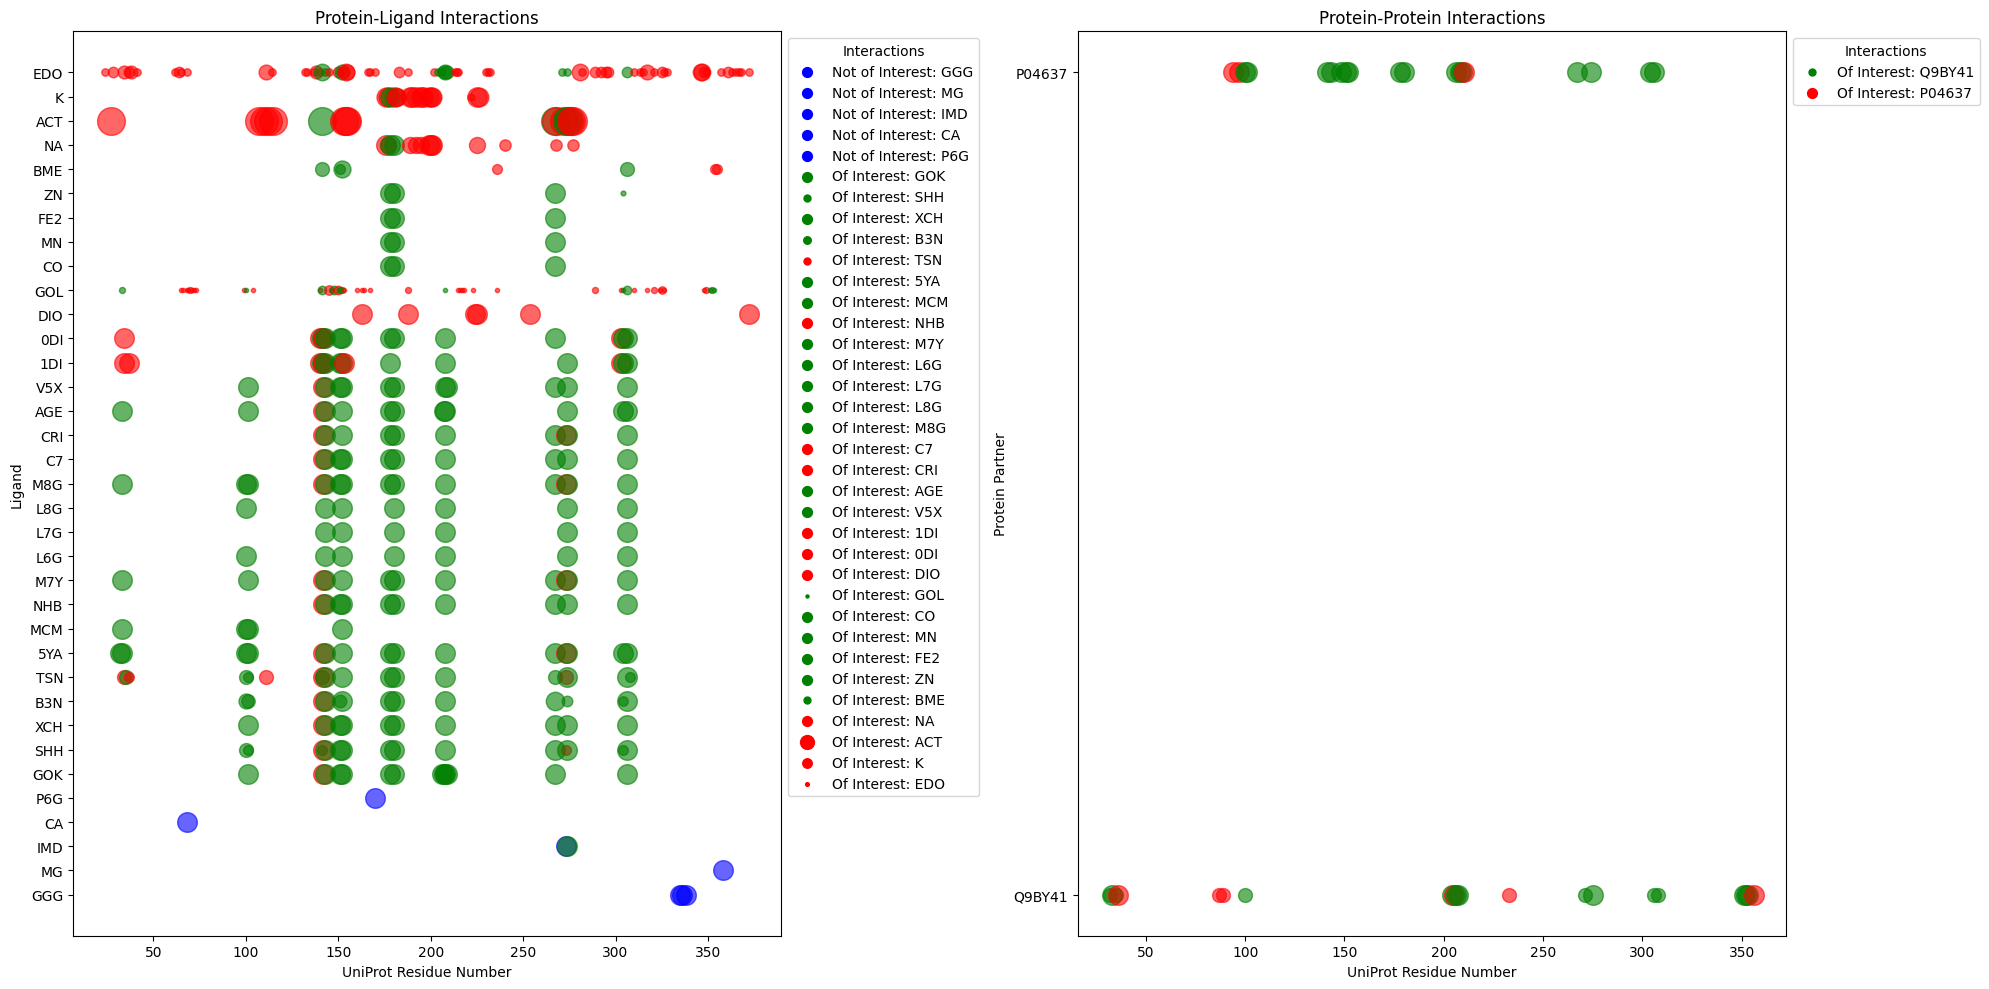

In [18]:
# Visualize the interactions
visualize_interactions(df_avg_interactions_protein_ligand, ligands_of_interest, df_avg_interactions_protein_protein, partners_of_interest, mode='both', include_not_of_interest=True, overlapping_residues=overlapping_residues)